In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

# === DATA LOADING ===
df = pd.read_csv('TabFairGAN_balanced_diabetes_final.csv')
TARGET = 'Diabetes_binary'

# Remove the 'source' column as it's not needed for prediction
df = df.drop(columns=['source'])

X = df.drop(columns=[TARGET]).values
y = df[TARGET].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# === FIXED ARCHITECTURE ===
FIXED_ARCHITECTURE = [128, 64]  # Fixed architecture [layer1_neurons, layer2_neurons]

# === GA HYPERPARAMETERS ===
POP_SIZE = 50
NUM_GENERATIONS = 50
ELITE_K = 2
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
LOCAL_EPOCHS = 5

# === UTILITY FUNCTIONS ===
def flatten_weights(weights):
    flat = np.concatenate([w.flatten() for w in weights])
    shapes = [w.shape for w in weights]
    sizes = [w.size for w in weights]
    return flat, shapes, sizes

def unflatten_weights(flat, shapes, sizes):
    weights, idx = [], 0
    for shape, size in zip(shapes, sizes):
        weights.append(flat[idx:idx+size].reshape(shape))
        idx += size
    return weights

def init_weights():
    """Initialize weights for the fixed architecture"""
    m = tf.keras.Sequential()
    m.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
    for n in FIXED_ARCHITECTURE:
        m.add(tf.keras.layers.Dense(n, activation='relu'))
    m.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return flatten_weights(m.get_weights())

# === CHROMOSOME ===
def create_chromosome():
    lr = 10**random.uniform(-5, -2)  # Learning rate
    batch = random.choice([16, 32, 64])  # Batch size
    flat_w, shapes, sizes = init_weights()
    return {
        'lr': lr,
        'batch': batch,
        'weights': flat_w,
        'shapes': shapes,
        'sizes': sizes
    }

# === FITNESS FUNCTION ===
def fitness(chrom):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
    for n in FIXED_ARCHITECTURE:
        model.add(tf.keras.layers.Dense(n, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    weights = unflatten_weights(chrom['weights'], chrom['shapes'], chrom['sizes'])
    model.set_weights(weights)

    # Single training/validation split (faster than KFold)
    train_idx, val_idx = train_test_split(np.arange(len(X_train)), test_size=0.2, random_state=42)
    
    model.compile(optimizer=Adam(chrom['lr']), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])
    model.fit(X_train[train_idx], y_train[train_idx],
              epochs=LOCAL_EPOCHS,
              batch_size=chrom['batch'],
              verbose=0)
    
    score = model.evaluate(X_train[val_idx], y_train[val_idx], verbose=0)[1]
    chrom['weights'], _, _ = flatten_weights(model.get_weights())  # Lamarckian update
    
    return score

# === SELECTION ===
def select_pair(pop, scores, k=3):
    idx = np.random.choice(len(pop), k, replace=False)
    return pop[idx[np.argmax([scores[i] for i in idx])]]

# === CROSSOVER ===
def crossover(p1, p2):
    c1, c2 = {}, {}
    
    # Blend learning rates geometrically
    c1['lr'] = np.exp(0.5*(np.log(p1['lr']) + np.log(p2['lr'])))
    c2['lr'] = c1['lr'] * 10**random.uniform(-0.1, 0.1)  # Small perturbation
    
    # Crossover batch sizes
    c1['batch'], c2['batch'] = (p1['batch'], p2['batch']) if random.random() < 0.5 else (p2['batch'], p1['batch'])
    
    # Blend weights (50-50 average)
    c1['weights'] = 0.5*p1['weights'] + 0.5*p2['weights']
    c2['weights'] = 0.5*p1['weights'] + 0.5*p2['weights']
    
    # Keep same shapes/sizes (fixed architecture)
    c1['shapes'], c1['sizes'] = p1['shapes'], p1['sizes']
    c2['shapes'], c2['sizes'] = p2['shapes'], p2['sizes']
    
    return c1, c2

# === MUTATION ===
def mutate(ch):
    if random.random() < MUTATION_RATE:
        prop = random.choice(['lr', 'batch', 'weights'])
        
        if prop == 'lr':
            ch['lr'] = 10**random.uniform(-5, -2)
        elif prop == 'batch':
            ch['batch'] = random.choice([16, 32, 64])
        elif prop == 'weights':
            # Adaptive weight mutation
            mutation_strength = random.uniform(0.005, 0.02)  # Random magnitude
            ch['weights'] += np.random.normal(0, mutation_strength, size=ch['weights'].shape)
    return ch

# === GA MAIN LOOP ===
population = [create_chromosome() for _ in range(POP_SIZE)]
best_overall, best_score = None, 0

for gen in range(NUM_GENERATIONS):
    scores = [fitness(ind) for ind in population]
    i_best = np.argmax(scores)
    if scores[i_best] > best_score:
        best_score = scores[i_best]
        best_overall = population[i_best].copy()
        print(f"Gen {gen+1:02d}: New best Val Acc = {best_score:.4f}")
    
    elites = [population[i] for i in np.argsort(scores)[-ELITE_K:]]
    new_pop = elites.copy()
    
    while len(new_pop) < POP_SIZE:
        p1 = select_pair(population, scores)
        p2 = select_pair(population, scores)
        if random.random() < CROSSOVER_RATE:
            c1, c2 = crossover(p1, p2)
        else:
            c1, c2 = p1.copy(), p2.copy()
        new_pop.extend([mutate(c1), mutate(c2)])
    
    population = new_pop[:POP_SIZE]
    print(f"Gen {gen+1:02d}: Best Val Acc = {best_score:.4f}")

# === FINAL MODEL TRAINING ===
def build_model(l2reg=0.01, dropout=0.3):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))
    for n in FIXED_ARCHITECTURE:
        model.add(tf.keras.layers.Dense(n, activation='relu', 
                                      kernel_regularizer=tf.keras.regularizers.l2(l2reg)))
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

model = build_model()
model.set_weights(unflatten_weights(best_overall['weights'], best_overall['shapes'], best_overall['sizes']))
model.compile(optimizer=Adam(learning_rate=best_overall['lr']), 
             loss='binary_crossentropy', 
             metrics=['accuracy'])

X_comb = np.vstack([X_train, X_val])
y_comb = np.concatenate([y_train, y_val])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_comb, y_comb, 
          epochs=100, 
          batch_size=best_overall['batch'], 
          validation_split=0.1, 
          callbacks=[es])


Gen 01: New best Val Acc = 0.8296
Gen 01: Best Val Acc = 0.8296
Gen 02: New best Val Acc = 0.8328
Gen 02: Best Val Acc = 0.8328
Gen 03: New best Val Acc = 0.8341
Gen 03: Best Val Acc = 0.8341
Gen 04: New best Val Acc = 0.8349
Gen 04: Best Val Acc = 0.8349
Gen 05: New best Val Acc = 0.8370
Gen 05: Best Val Acc = 0.8370
Gen 06: New best Val Acc = 0.8371
Gen 06: Best Val Acc = 0.8371
Gen 07: New best Val Acc = 0.8374
Gen 07: Best Val Acc = 0.8374
Gen 08: New best Val Acc = 0.8385
Gen 08: Best Val Acc = 0.8385
Gen 09: Best Val Acc = 0.8385
Gen 10: New best Val Acc = 0.8390
Gen 10: Best Val Acc = 0.8390
Gen 11: Best Val Acc = 0.8390
Gen 12: Best Val Acc = 0.8390
Gen 13: Best Val Acc = 0.8390
Gen 14: Best Val Acc = 0.8390
Gen 15: New best Val Acc = 0.8392
Gen 15: Best Val Acc = 0.8392
Gen 16: New best Val Acc = 0.8395
Gen 16: Best Val Acc = 0.8395
Gen 17: Best Val Acc = 0.8395
Gen 18: New best Val Acc = 0.8401
Gen 18: Best Val Acc = 0.8401
Gen 19: Best Val Acc = 0.8401
Gen 20: Best Val Acc =


Final Test Metrics:
Accuracy:  0.8280
Precision: 0.7944
Recall:    0.7237
F1 Score:  0.7574


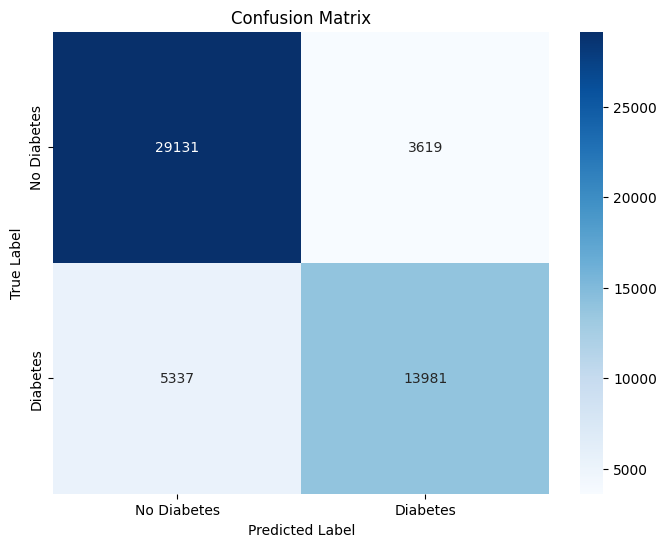


Detailed Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.85      0.89      0.87     32750
    Diabetes       0.79      0.72      0.76     19318

    accuracy                           0.83     52068
   macro avg       0.82      0.81      0.81     52068
weighted avg       0.83      0.83      0.83     52068



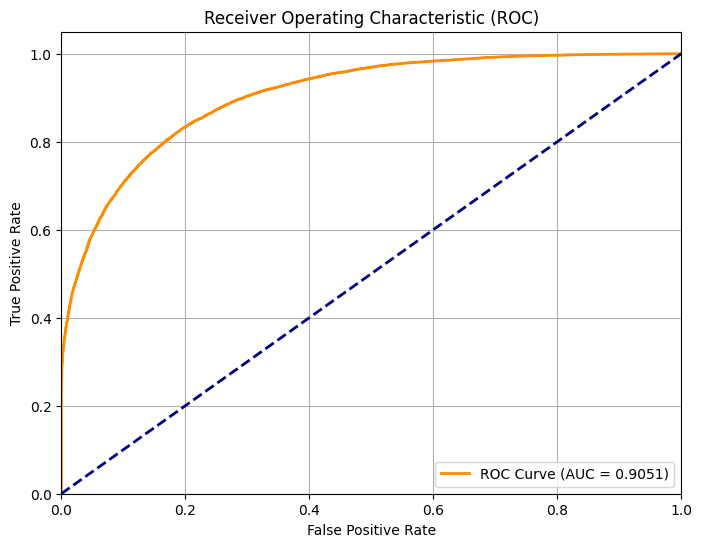

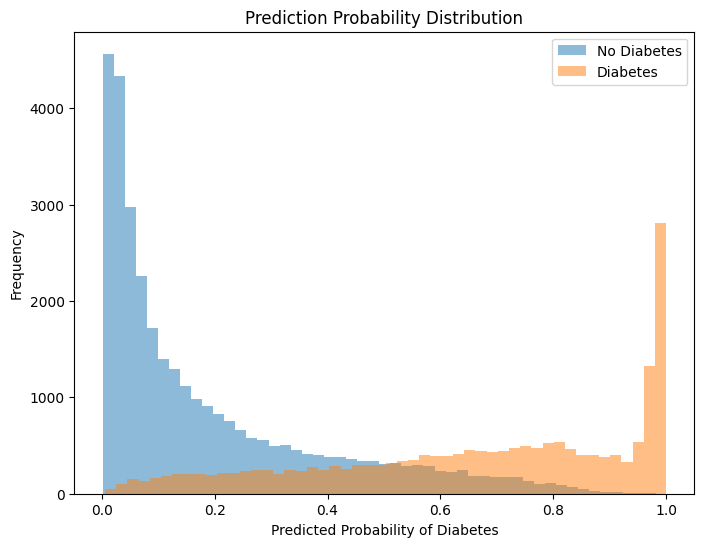

In [ ]:
# === TEST EVALUATION WITH PLOTS ===
# Get probability predictions
y_pred_proba = model.predict(X_test, verbose=0).flatten()
y_pred_classes = (y_pred_proba > 0.5).astype(int)

# Print standard metrics
print("\nFinal Test Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_classes):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_classes):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_classes):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_classes):.4f}")

# Import additional metrics if needed
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Confusion Matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_classes, 
                           target_names=['No Diabetes', 'Diabetes']))

# 3. ROC Curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 4. Prediction Distribution
plt.figure(figsize=(8,6))
plt.hist(y_pred_proba[y_test==0], bins=50, alpha=0.5, label='No Diabetes')
plt.hist(y_pred_proba[y_test==1], bins=50, alpha=0.5, label='Diabetes')
plt.title('Prediction Probability Distribution')
plt.xlabel('Predicted Probability of Diabetes')
plt.ylabel('Frequency')
plt.legend()
plt.show()


ROC AUC Score: 0.9051
Interpretation:
0.90-1.00 = Excellent | 0.80-0.90 = Good | 0.70-0.80 = Fair | 0.60-0.70 = Poor | 0.50-0.60 = Fail


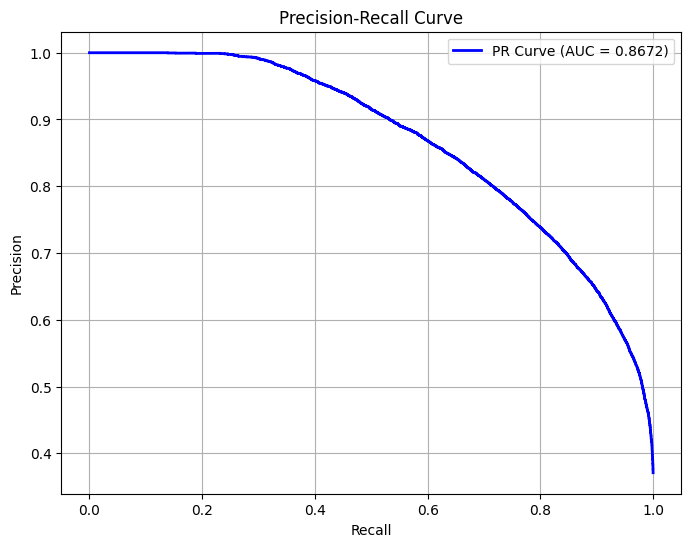


Precision-Recall AUC Score: 0.8672
Interpretation:
1.0 = Perfect | >0.8 = Strong | >0.6 = Moderate | <0.6 = Weak

AUC Performance Summary:
| Metric   |    Score | Interpretation                                |
|:---------|---------:|:----------------------------------------------|
| ROC AUC  | 0.905062 | Discrimination ability (higher=better)        |
| PR AUC   | 0.867195 | Important for class imbalance (higher=better) |


In [ ]:
# === AUC-SPECIFIC EVALUATION ===
from sklearn.metrics import auc, precision_recall_curve

# 1. ROC AUC (already in code but with more details)
print(f"\nROC AUC Score: {roc_auc:.4f}")
print("Interpretation:")
print("0.90-1.00 = Excellent | 0.80-0.90 = Good | 0.70-0.80 = Fair | 0.60-0.70 = Poor | 0.50-0.60 = Fail")

# 2. Precision-Recall AUC (especially important for imbalanced datasets)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print(f"\nPrecision-Recall AUC Score: {pr_auc:.4f}")
print("Interpretation:")
print("1.0 = Perfect | >0.8 = Strong | >0.6 = Moderate | <0.6 = Weak")

# 3. AUC Comparison Table
import pandas as pd
auc_scores = pd.DataFrame({
    'Metric': ['ROC AUC', 'PR AUC'],
    'Score': [roc_auc, pr_auc],
    'Interpretation': [
        'Discrimination ability (higher=better)',
        'Important for class imbalance (higher=better)'
    ]
})
print("\nAUC Performance Summary:")
print(auc_scores.to_markdown(index=False))

/opt/anaconda3/envs/TF/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/opt/anaconda3/envs/TF/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_17850
Received: inputs=['Tensor(shape=(100, 21))']
  warnings.warn(msg)
/opt/anaconda3/envs/TF/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_17850
Received: inputs=['Tensor(shape=(200, 21))']
  warnings.warn(msg)


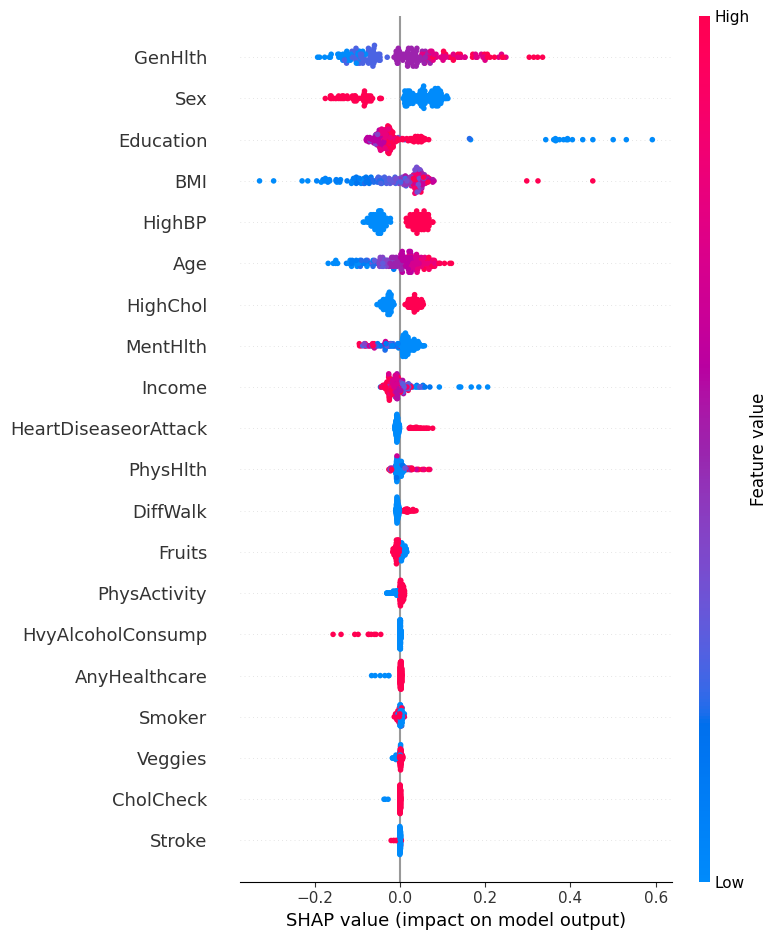

In [8]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Prepare data
X1 = df.drop(columns=[TARGET])  # DataFrame with feature names
y1 = df[TARGET]

# Split data into train/test; keep X_train as DataFrame to preserve column names
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1)

# Select a sample from training data for SHAP background
X_sample = X_train.iloc[:100]  # DataFrame slice with column names

# Build DeepExplainer with trained model and background data (numpy array)
explainer = shap.DeepExplainer(model, X_sample.values)

# Select test samples to explain
X_test_sample = X_test.iloc[:200]

# Calculate SHAP values (returns list for binary classification)
shap_values = explainer.shap_values(X_test_sample.values)

# If shap_values is a list (e.g., for binary classification), take the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Remove any extra singleton dimension, e.g. shape (200, 21, 1) -> (200, 21)
shap_values = np.squeeze(shap_values)

# Plot SHAP summary plot with real feature names
shap.summary_plot(shap_values, X_test_sample, feature_names=X_sample.columns.tolist())